In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

In [6]:
from Scratch import create_or_load_kde_grid

grid_dict, processed_scaler_dict = create_or_load_kde_grid(provider, tobecalib_backend=DEVICE, 
                                                           num_grid_points=300, num_std_dev=2, other_date=OTHER_DATE)

Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Searching for ibm_sherbrooke and 23.10.27_07h46_300pts_2std


# Generate IQ data

In [35]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 5
ROUNDS = 5
OTHER_DATE = '2021-11-11'
_RESETS = False

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.


In [65]:
# Get noise model
p1Q = 0
pZ = 0
pRE = 0
pXY = 0

p2Q = 1e-2
# pRO = 15e-2
pRO = 0


p1Q = 1e-4
p2Q = 6e-3
pXY = 1e-4
pZ = 1e-4
pRO = 1e-1
pRE = 1e-3

noise_model = simulator.get_noise_model(p1Q, p2Q, pXY, pZ, pRO, pRE)

In [66]:
SHOTS = int(1e4)
LOGICAL = 1
IQ_data = simulator.generate_IQ(SHOTS, noise_model=noise_model, logical=LOGICAL)

19:05:32 Warning: Getting counts via stim. This may take time.... IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/IQ_data/simulator.py, LINE: 46


100%|██████████| 4374/4374 [00:00<00:00, 41522.31it/s]


# Get decoding results

In [67]:
import pymatching
import stim


circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=DISTANCE,
                                rounds=ROUNDS,
                                after_clifford_depolarization=p2Q, #two-qubit-fidelity,
                                after_reset_flip_probability=pRE, #reset error,
                                before_measure_flip_probability=pRO, #measurement error,
                                before_round_data_depolarization=(pXY + pZ)/2) #idle error)
# print(circuit)

model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

In [68]:
from src import cpp_soft_info

matching = pymatching.Matching.from_detector_error_model(model)
# cpp_soft_info.reweight_edges_based_on_error_probs(matching._matching_graph, counts, False, "spitz")

result = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, grid_dict,
                                           processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _bimodal=False, merge_strategy = "replace", _detailed=True)
print("num_errors:", result.num_errors, "out of", len(IQ_data), "shots")

num_errors: 309 out of 10000 shots


In [69]:
matching = pymatching.Matching.from_detector_error_model(model)
result_flat = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, grid_dict,
                                           processed_scaler_dict, _detailed=True)
print("num_errors:", result_flat.num_errors, "out of", len(IQ_data), "shots")


num_errors: 349 out of 10000 shots


In [70]:
matching = pymatching.Matching.from_detector_error_model(model)

import numpy as np
def weight_to_prob(weight):
    return 1/(1+np.exp(weight))

p_data = 6.869e-3# mean sherbrooke ECR error
p_mixed = p_data/10# Same as weighted
# p_meas = 1e-3
p_meas = 49.900e-2 # random found number


# p_data = -1
# p_mixed = -1
# p_meas = -1

result_informed = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, IQ_data, 
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, grid_dict, processed_scaler_dict,
                                           p_data = p_data, p_mixed = p_mixed, p_meas = p_meas, common_measure=-1, _detailed=True)

print("num_errors:", result_informed.num_errors, "out of", len(IQ_data), "shots")
         
# takes 1s

num_errors: 111 out of 10000 shots


# Plot the results

In [71]:
print("\nIQ:", result.indices, "\nFlat:", result_flat.indices, "\nInformed", result_informed.indices)


IQ: [202, 987, 988, 989, 1131, 1240, 1336, 1491, 1496, 1707, 1708, 2125, 2170, 2258, 2875, 3198, 3210, 3219, 3311, 3344, 3366, 3392, 3399, 3404, 3469, 3515, 3638, 3671, 3688, 3702, 3799, 3810, 3883, 3968, 3979, 4077, 4079, 4081, 4331, 4336, 4566, 4600, 4616, 4653, 4678, 4824, 4863, 4934, 4981, 5015, 5019, 5060, 5130, 5142, 5143, 5199, 5202, 5221, 5253, 5377, 5380, 5418, 5442, 5545, 5602, 5629, 5756, 5812, 5827, 5837, 5865, 5878, 5921, 5928, 5960, 5963, 5982, 6040, 6121, 6159, 6172, 6189, 6227, 6246, 6263, 6317, 6319, 6334, 6363, 6385, 6387, 6409, 6418, 6422, 6425, 6428, 6429, 6432, 6438, 6530, 6563, 6566, 6577, 6578, 6636, 6645, 6649, 6663, 6665, 6674, 6676, 6685, 6703, 6744, 6762, 6789, 6795, 6815, 6833, 6860, 6875, 6885, 6928, 6942, 6949, 6961, 6984, 7051, 7061, 7077, 7082, 7092, 7109, 7114, 7140, 7144, 7186, 7261, 7297, 7299, 7319, 7349, 7365, 7370, 7386, 7391, 7392, 7403, 7413, 7483, 7493, 7508, 7511, 7517, 7520, 7563, 7571, 7619, 7657, 7662, 7765, 7776, 7777, 7806, 7807, 7846, 78

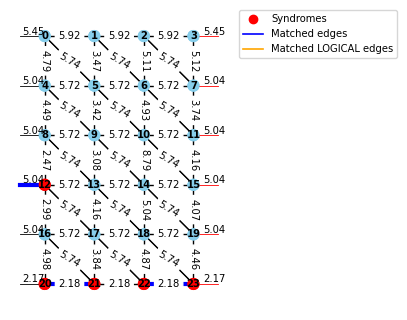

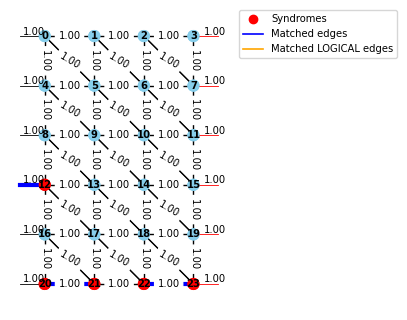

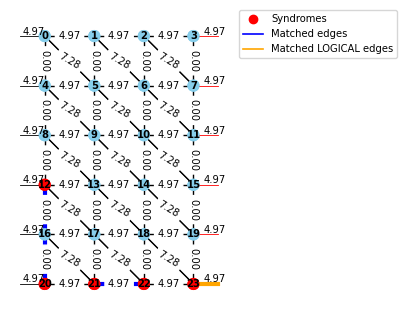

In [75]:
from soft_info import draw_matching_graph


index = 5922

fig_size = (3,3)
scale_factor = 0.6

to_be_result = result
details = to_be_result.error_details[index]
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_flat
details = to_be_result.error_details[index]
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_informed
details = to_be_result.error_details[index]
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)


In [74]:
print("the set of elements that are in result_informed but not in result_flat or result:")
print(set(result_informed.indices).difference(set(result_flat.indices + result.indices)))

the set of elements that are in result_informed but not in result_flat or result:
{5922, 9635, 7691, 5516, 9038, 4884, 6558, 7647}
